# Topic Modeling on our Hon.PM Shri Narendra Modi's Speech (Recorded Session Transcript)

![Topic Modeling PM US Speech](https://cdn.zeebiz.com/sites/default/files/2023/06/23/248256-india-us-joint-statement-2023-full-text-details-of-president-joe-biden-and-pm-narendra-modi.jpg)

After converting the speech-to-text recorded session of our Hon.PM Shri Narendra Modi during his America Visit in 2023, now it is time to preprocess the text and implement various topic modeling algorithms, namely, **Latent Dirichlet Allocation (LDA)**, **Latent Semantic Analysis (LSA)**, and **BERTopic**.

So, without further ado, Let’s begin.


### Downloading required packages

In [ ]:
pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 21.4 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [ ]:
pip install lexrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.2 MB/s eta 0:00:00


In [ ]:
pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 36.4 MB/s eta 0:00:00


### Importing the Relevant Libraries

In [ ]:
# Importing general libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pdfplumber

# Importing the Gensim library
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# I will use this library for implementing the truncated singular value decomposition for the LSA model
from gensim.models import LsiModel


# Importing nltk and downloading stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Importing spacy for lemmatization
import spacy

# Importing the BERTopic model
from bertopic import BERTopic
# Importing the sentence-transformers package for the purpose of document embeddings
from sentence_transformers import SentenceTransformer
from sentence_transformers import *
# Importing UMAP for dimensionality reduction in the BERTopic model
import umap
# Importing HDBSCAN to perform its clustering
import hdbscan

# Importing various dimensionality reduction and clustering techniques
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Importing LexRank, an unsupervised approach to text summarization based on graph-based centrality scoring of sentences
from lexrank import *
# Importing the torch package
import torch


# Importing plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Enabling logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Importing warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Preparing Stopwords

In [ ]:
# Importing NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### Importing our Corpus Document

In [ ]:
# Open the PDF file
with pdfplumber.open('/content/drive/MyDrive/Topic Modeling/USA2023.pdf') as pdf:
    # Extract text from all pages
    text = ''
    for page in pdf.pages:
        text += page.extract_text()

# Tokenize the text into sentences
sentences = nltk.sent_tokenize(text)

# Create a DataFrame from the sentences
df = pd.DataFrame(sentences, columns=['sentence'])

# Display the first 10 sentences of the DataFrame
print(df.head(10))


                                            sentence
0  Mister Speaker,\nMadam Vice President,\nDistin...
1  It is always a great honour to address the Uni...
2    It is an exceptional privilege to do\nso twice.
3  For this honour, I extend my deepest gratitude...
4  I\nsee that nearly half of you were here in 2016.
5                 I feel your warmth as old friends.
6  I can also see the\nenthusiasm of a new friend...
7  I remember Senator Harry Reid, Senator John\nM...
8  Mister Speaker,\nStanding here, seven Junes ag...
9  Now, when our era is at a crossroads, I am her...


In [ ]:
from wordcloud import WordCloud
wordcloud1 = WordCloud().generate(' '.join(sentences))

(-0.5, 399.5, 199.5, -0.5)

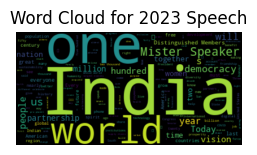

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Word Cloud for 2023 Speech')
plt.axis('off')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df['sentence'].shape

(231,)

There are only 231 sentences in my corpus from the recoded session of our Hon.PM Narendra Modi's Speech. This is a very small dataset, but to test our hypostasis of how well different types of topic models cope with this type of small dataset we will have to implement this corpus and reach the relevant conclusions based on the results.

So, let's continue

### Removing Emails and Newline Characters

In [ ]:
# Converting to list
data = df.sentence.values.tolist()

# Removing new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]



# Removing distracting single marks
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub(",", "", sent) for sent in data]
data = [re.sub("\[", "", sent) for sent in data]
data = [re.sub("\]", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]


print(data)

['Mister Speaker Madam Vice President Distinguished Members of the US Congress Ladies and Gentlemen Namaskar!', 'It is always a great honour to address the United States Congress.', 'It is an exceptional privilege to do so twice.', 'For this honour I extend my deepest gratitude on behalf of the 1.4 billion people of India.', 'I see that nearly half of you were here in 2016.', 'I feel your warmth as old friends.', 'I can also see the enthusiasm of a new friendship in the other half.', 'I remember Senator Harry Reid Senator John McCain Senator Orrin Hatch Elijah Cummings Alcee Hastings and others who I met here in 2016 and who are sadly no longer with us.', 'Mister Speaker Standing here seven Junes ago that’s the June when Hamilton swept all the awards I said that the hesitations of history were behind us.', 'Now when our era is at a crossroads I am here to speak about our calling for this century.', 'Through the long and winding road that we have travelled we have met the test of friend

### Tokenizing Words and Clean-Up Text

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words)

[['mister', 'speaker', 'madam', 'vice', 'president', 'distinguished', 'members', 'of', 'the', 'us', 'congress', 'ladies', 'and', 'gentlemen', 'namaskar'], ['it', 'is', 'always', 'great', 'honour', 'to', 'address', 'the', 'united', 'states', 'congress'], ['it', 'is', 'an', 'exceptional', 'privilege', 'to', 'do', 'so', 'twice'], ['for', 'this', 'honour', 'extend', 'my', 'deepest', 'gratitude', 'on', 'behalf', 'of', 'the', 'billion', 'people', 'of', 'india'], ['see', 'that', 'nearly', 'half', 'of', 'you', 'were', 'here', 'in'], ['feel', 'your', 'warmth', 'as', 'old', 'friends'], ['can', 'also', 'see', 'the', 'enthusiasm', 'of', 'new', 'friendship', 'in', 'the', 'other', 'half'], ['remember', 'senator', 'harry', 'reid', 'senator', 'john', 'mccain', 'senator', 'orrin', 'hatch', 'elijah', 'cummings', 'alcee', 'hastings', 'and', 'others', 'who', 'met', 'here', 'in', 'and', 'who', 'are', 'sadly', 'no', 'longer', 'with', 'us'], ['mister', 'speaker', 'standing', 'here', 'seven', 'junes', 'ago', 

### Creating Bigram and Trigram Models

In [ ]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
data_words = [trigram_mod[bigram_mod[word]] for word in data_words]
print(data_words)


[['mister_speaker', 'madam', 'vice', 'president', 'distinguished_members', 'of', 'the', 'us', 'congress', 'ladies', 'and', 'gentlemen', 'namaskar'], ['it', 'is', 'always', 'great', 'honour', 'to', 'address', 'the', 'united', 'states', 'congress'], ['it', 'is', 'an', 'exceptional', 'privilege', 'to', 'do', 'so', 'twice'], ['for', 'this', 'honour', 'extend', 'my', 'deepest', 'gratitude', 'on', 'behalf', 'of', 'the', 'billion', 'people', 'of', 'india'], ['see', 'that', 'nearly', 'half', 'of', 'you', 'were', 'here', 'in'], ['feel', 'your', 'warmth', 'as', 'old', 'friends'], ['can', 'also', 'see', 'the', 'enthusiasm', 'of', 'new', 'friendship', 'in', 'the', 'other', 'half'], ['remember', 'senator', 'harry', 'reid', 'senator', 'john', 'mccain', 'senator', 'orrin', 'hatch', 'elijah', 'cummings', 'alcee', 'hastings', 'and', 'others', 'who', 'met', 'here', 'in', 'and', 'who', 'are', 'sadly', 'no', 'longer', 'with', 'us'], ['mister_speaker', 'standing', 'here', 'seven', 'junes', 'ago', 'that', '

### Removing Stopwords and Making Bigrams and Lemmatization

In [ ]:
# Defining functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initializing spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Preforming lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

[['vice', 'ladie', 'gentleman'], ['always', 'great', 'honour', 'address'], ['exceptional', 'privilege', 'twice'], ['extend', 'deep', 'gratitude', 'behalf', 'people'], ['see', 'nearly', 'half'], ['feel', 'warmth', 'old', 'friend'], ['also', 'see', 'enthusiasm', 'new', 'friendship', 'half'], ['remember', 'cumming', 'alcee', 'other', 'meet', 'sadly', 'long'], ['stand', 'june', 'ago', 'award', 'say', 'hesitation', 'history'], ['era', 'crossroad', 'speak', 'call', 'century'], ['long', 'winding', 'road', 'travel', 'meet', 'test', 'friendship'], ['lot', 'change', 'come', 'summer'], ['lot', 'remain', 'commitment', 'deepen', 'friendship'], ['past', 'year', 'many', 'advance', 'ai', 'artificial', 'intelligence'], ['time', 'even', 'momentous', 'development'], ['mister_speaker', 'beauty', 'democracy', 'constant', 'connect', 'people', 'listen', 'feel', 'pulse'], ['know', 'take', 'lot', 'time', 'energy', 'effort', 'travel'], ['afternoon', 'fly', 'day'], ['grateful', 'time'], ['also', 'know', 'busy', 

In [ ]:
len(data_lemmatized)

231

### Creating the Dictionary and Corpus needed for Topic Modeling

In [ ]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Creating Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Viewing the Term Document Frequency
print(corpus)

[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1)], [(15, 1), (17, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)], [(33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)], [(40, 1), (41, 1), (42, 1), (43, 1), (44, 1)], [(24, 1), (28, 1), (29, 1), (45, 1), (46, 1), (47, 1), (48, 1)], [(49, 1), (50, 1), (51, 1), (52, 1)], [(24, 1), (51, 1), (53, 1), (54, 1), (55, 1)], [(56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(63, 1), (64, 1), (65, 1), (66, 1)], [(14, 1), (18, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1)], [(47, 1), (51, 1), (66, 1), (74, 1), (75, 1), (76, 1), (77, 1)], [(78, 1), (79, 1), (80, 1)], [(66, 1), (81, 1)], [(22, 1), (76, 1), (82, 1), (83, 1), (84, 1)], [(70, 1), (72, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

[[('gentleman', 1), ('ladie', 1), ('vice', 1)],
 [('address', 1), ('always', 1), ('great', 1), ('honour', 1)],
 [('exceptional', 1), ('privilege', 1), ('twice', 1)],
 [('behalf', 1), ('deep', 1), ('extend', 1), ('gratitude', 1), ('people', 1)],
 [('half', 1), ('nearly', 1), ('see', 1)],
 [('feel', 1), ('friend', 1), ('old', 1), ('warmth', 1)],
 [('half', 1),
  ('see', 1),
  ('also', 1),
  ('enthusiasm', 1),
  ('friendship', 1),
  ('new', 1)],
 [('alcee', 1),
  ('cumming', 1),
  ('long', 1),
  ('meet', 1),
  ('other', 1),
  ('remember', 1),
  ('sadly', 1)],
 [('ago', 1),
  ('award', 1),
  ('hesitation', 1),
  ('history', 1),
  ('june', 1),
  ('say', 1),
  ('stand', 1)],
 [('call', 1), ('century', 1), ('crossroad', 1), ('era', 1), ('speak', 1)],
 [('friendship', 1),
  ('long', 1),
  ('meet', 1),
  ('road', 1),
  ('test', 1),
  ('travel', 1),
  ('winding', 1)],
 [('change', 1), ('come', 1), ('lot', 1), ('summer', 1)],
 [('friendship', 1),
  ('lot', 1),
  ('commitment', 1),
  ('deepen', 1)

### Building the LDA Topic Model

**Latent Dirichlet Allocation (LDA)** is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar. In this, observations (e.g., words) are collected into documents, and each word's presence is attributable to one of the document's topics. Each document will contain a small number of topics.
LDA is one of the most popular topic modeling methods.

In [ ]:
# Building the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1, # Determines how often the model parameters should be updated
                                           chunksize=10, # The number of documents to be used in each training chunk
                                           passes=10, # Total number of training passes
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/gensim/models/ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


### Viewing the Topics in The LDA Model

In [ ]:
# Printing the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"region" + 0.024*"institution" + 0.024*"work" + 0.023*"great" + '
  '0.018*"year" + 0.016*"rise" + 0.016*"honour" + 0.014*"take" + 0.011*"cause" '
  '+ 0.010*"vice"'),
 (1,
  '0.031*"nation" + 0.024*"together" + 0.022*"century" + 0.018*"see" + '
  '0.017*"prosperity" + 0.017*"progress" + 0.016*"light" + 0.014*"benefit" + '
  '0.013*"base" + 0.013*"live"'),
 (2,
  '0.025*"give" + 0.020*"destiny" + 0.019*"also" + 0.016*"high" + '
  '0.015*"share" + 0.014*"deliver" + 0.013*"purpose" + 0.012*"large" + '
  '0.012*"human" + 0.012*"suffering"'),
 (3,
  '0.049*"partnership" + 0.039*"new" + 0.029*"democracy" + 0.022*"country" + '
  '0.022*"free" + 0.019*"vision" + 0.018*"relationship" + 0.016*"global" + '
  '0.015*"order" + 0.014*"partner"'),
 (4,
  '0.059*"world" + 0.020*"say" + 0.019*"future" + 0.016*"force" + 0.015*"well" '
  '+ 0.015*"come" + 0.015*"today" + 0.015*"international" + 0.015*"grow" + '
  '0.014*"change"')]


### Computing Model Perplexity and Coherence Score

In [ ]:
# Computing Perplexity
print('\nPerplexity Score: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Computing Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity Score:  -7.607041857027111

Coherence Score:  0.6163773090238039


### Visualizing the Topics-Keywords

In [ ]:
# Visualizing the topics using pyLDAvis package's interactive chart
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.116281  0.146550       1        1  22.549626
3     -0.177918  0.066568       2        1  21.766755
1     -0.006304 -0.094206       3        1  18.830229
2      0.008733 -0.024754       4        1  18.674099
0      0.059209 -0.094159       5        1  18.179291, topic_info=            Term       Freq      Total Category  logprob  loglift
105        world  18.000000  18.000000  Default  30.0000  30.0000
182  partnership  15.000000  15.000000  Default  29.0000  29.0000
25           new  12.000000  12.000000  Default  28.0000  28.0000
114       nation   8.000000   8.000000  Default  27.0000  27.0000
555       region   8.000000   8.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
666        write   1.881396   2.554297   Topic5  -4.8658   1.3991
667          मनत   1.881396   2.554297   Topic5  -4.8658   1.3991
668        वनशचय   1.881396   2.554297   Topic5  -4.8658   1.3991
669         सकलप   1.881396   2.554297   Topic5  -4.8658   1.3991
656        light   1.881598   6.567487   Topic5  -4.8657   0.4549

[197 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
56        1  0.753536  advance
22        4  0.937153     also
4         3  0.728317   always
670       1  0.768378      arm
564       3  0.779548     base
...     ...       ...      ...
62        5  0.823691     year
328       2  0.694211    young
667       5  0.782994      मनत
668       5  0.782994    वनशचय
669       5  0.782994     सकलप

[172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])

# Latent Semantic Analysis (LSA) Topic Modeling
Latent Semantic Analysis (LSA) also known as Latent Semantic Index (LSI) is a natural language processing method that analyzes relationships between a set of documents and the terms contained within. It uses singular value decomposition, a mathematical technique, to scan unstructured data to find hidden relationships between terms and concepts.





  







Again, We can obtain the coherence score with the Gensim module. Let’s see how the coherence score is for the LSA model for a total of 5 topics (The same number of topics as We initially chose for the LDA model. For comparison purposes).  
**Note** - LsiModel does not function with the log_preplexity for the calculation of the perplexity score the same as LDA does. So, I will drop the perplexity score and focus my attention only to the coherence score.

In [ ]:
lsi = LsiModel(corpus, num_topics=5, id2word=id2word, chunksize=10)

# Computing Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)

/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:102: RuntimeWarning: invalid value encountered in divide
  rel_spectrum = np.abs(1.0 - np.cumsum(s / np.sum(s)))



Coherence Score:  0.5468423590495167


We get a better Coherence Score this time by using LsiModel

### Performing SVD

In [ ]:
# performing SVD on the bag of words with the LsiModel to extract 5 topics
lsi = LsiModel(corpus, num_topics=5, id2word=id2word)

In [ ]:
# finding the 10 words with the srongest association to the derived topics
for topic_num, words in lsi.print_topics(num_words=10):
    print('Words in {}: {}.'.format(topic_num, words))

Words in 0: -0.681*"world" + -0.203*"year" + -0.184*"together" + -0.179*"well" + -0.172*"democracy" + -0.158*"also" + -0.141*"celebrate" + -0.139*"future" + -0.131*"grow" + -0.119*"new".
Words in 1: 0.354*"year" + 0.309*"get" + 0.247*"check" + 0.216*"phone" + 0.203*"payment" + -0.191*"world" + 0.173*"last" + 0.154*"farmer" + 0.147*"small" + 0.134*"medicine".
Words in 2: 0.424*"year" + -0.312*"nation" + -0.222*"free" + -0.182*"share" + 0.169*"celebrate" + -0.165*"progress" + -0.158*"region" + -0.152*"small" + 0.150*"world" + -0.147*"democracy".
Words in 3: 0.349*"year" + 0.259*"free" + 0.241*"nation" + -0.219*"check" + -0.209*"get" + 0.155*"share" + 0.154*"last" + -0.147*"world" + 0.133*"people" + -0.132*"deliver".
Words in 4: 0.342*"democracy" + -0.277*"world" + 0.250*"partnership" + 0.204*"great" + 0.182*"science" + 0.163*"grow" + 0.158*"time" + 0.157*"technology" + 0.142*"humanity" + -0.134*"nation".


### BERTopic

**BERTopic** is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.






After preprocessing the dataset early in my project and reaching to a final lemmatized dataset (named: **data_lemmatized**) containing the final product words that We have been working with. Now, We want to add those words to my dataframe as a set of rows and their corresponding words. After doing that, We would like to convert does words back to sentences for the purpose of using the sentence transformer model from BERTopic.

In [ ]:
# Adding new column to the dataframe (named: text_cleaned)
# containing the different lemmatized words in each corresponding row.
df['text_cleaned'] = data_lemmatized

In [ ]:
# Function to make it back into a sentence
def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Removing double spaces if created
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [ ]:
# Converting all the texts back to sentences
make_sentences(df, 'text_cleaned')

In [ ]:
df.head()

,sentence,text_cleaned
0,"Mister Speaker,\nMadam Vice President,\nDistin...",vice ladie gentleman
1,It is always a great honour to address the Uni...,always great honour address
2,It is an exceptional privilege to do\nso twice.,exceptional privilege twice
3,"For this honour, I extend my deepest gratitude...",extend deep gratitude behalf people
4,I\nsee that nearly half of you were here in 2016.,see nearly half


### Importing a Pre-Trained Model from SentenceTransformer

In [ ]:
# Getting a model
model=SentenceTransformer('all-MiniLM-L12-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Encodinng The Preprocessed Text Data

In [ ]:
embeddings = model.encode(df['text_cleaned'])

### Getting Topics Using BERTopic and SentenceTransformer Embeddings

In [ ]:
model2 = BERTopic()
topics, probabilities = model2.fit_transform(df['text_cleaned'],embeddings)

In [ ]:
# viewing how frequent certain topics are
model2.get_topic_freq().head()

,Topic,Count
1,-1,114
2,0,50
0,1,33
3,2,21
4,3,13


After generating topics and their probabilities, We can access the frequent topics that were generated.

In [ ]:
model2.get_topic(0)

[('grow', 0.06771052597394091),
 ('world', 0.06487988416361191),
 ('phone', 0.04526849102546032),
 ('region', 0.04324311334544152),
 ('work', 0.0415369801148486),
 ('make', 0.03877036871122848),
 ('institution', 0.0382052389830248),
 ('payment', 0.0382052389830248),
 ('account', 0.0382052389830248),
 ('get', 0.0382052389830248)]

In [ ]:
model2.get_topic(1)

[('honour', 0.17359482210633045),
 ('hear', 0.10647477825980241),
 ('vice', 0.10647477825980241),
 ('tribute', 0.10647477825980241),
 ('pay', 0.10647477825980241),
 ('house', 0.10647477825980241),
 ('meet', 0.09774128458551584),
 ('want', 0.09774128458551584),
 ('long', 0.09156799125822791),
 ('know', 0.082913969501477)]

In [ ]:
model2.get_topic(2)

[('democracy', 0.3292660400145627),
 ('understand', 0.08029245573690019),
 ('ideology', 0.08029245573690019),
 ('equality', 0.08029245573690019),
 ('party', 0.08029245573690019),
 ('debate', 0.08029245573690019),
 ('idea', 0.07370654247432343),
 ('different', 0.07370654247432343),
 ('also', 0.07055700857454915),
 ('diversity', 0.0690512720963686)]

In [ ]:
model2.get_topic(3)

[('history', 0.27069023108105766),
 ('scripture', 0.16602846779494615),
 ('year', 0.15591164869626248),
 ('live', 0.15241013867571962),
 ('ago', 0.15241013867571962),
 ('old', 0.1427839863687622),
 ('celebrate', 0.12928957956162515),
 ('world', 0.12123741066166466),
 ('great', 0.1124683312787493),
 ('unite', 0.09469912980339407)]

In [ ]:
model2.get_topics()

{-1: [('woman', 0.05359960860618909),
  ('world', 0.04237107136210036),
  ('also', 0.041718683583659114),
  ('century', 0.039960914302031726),
  ('future', 0.03551109834697557),
  ('vision', 0.034252212258884335),
  ('nation', 0.033145846723719084),
  ('lead', 0.032251057418785145),
  ('partnership', 0.03215976516371345),
  ('country', 0.03215976516371345)],
 0: [('grow', 0.06771052597394091),
  ('world', 0.06487988416361191),
  ('phone', 0.04526849102546032),
  ('region', 0.04324311334544152),
  ('work', 0.0415369801148486),
  ('make', 0.03877036871122848),
  ('institution', 0.0382052389830248),
  ('payment', 0.0382052389830248),
  ('account', 0.0382052389830248),
  ('get', 0.0382052389830248)],
 1: [('honour', 0.17359482210633045),
  ('hear', 0.10647477825980241),
  ('vice', 0.10647477825980241),
  ('tribute', 0.10647477825980241),
  ('pay', 0.10647477825980241),
  ('house', 0.10647477825980241),
  ('meet', 0.09774128458551584),
  ('want', 0.09774128458551584),
  ('long', 0.091567991

We can view all the topics discussed in all of the documents.

There is some favorable advantage for the LDA model over the other two models with regards to the interpretation and insights regarding the theme discussed in the recorded session. Explaining the results and reaching the relevant conclusions will take part in the paper that will be submitted along side this code implementation.



 ### THANK YOU

      
        
          
          





















![Thank You NLP](https://miro.medium.com/max/960/0*xLRsbQ02J7sQpNNy)


